#### モデルフリーの強化学習
１．Q-Learning\
    Q-learningはTD学習の中でも方策オフ型の手法です。方策はε-greedyなりsoftmaxなりを使いますので、方策を改善することはありません。


##### Q-Learningの学習フロー
１．Q関数の初期化、方策の決定、初期状態の決定\
２．方策に従って報酬、次の状態の観測\
３．TD Errorの計算\
$\delta_t:=r_t+\gamma \max _{a^{\prime} \in \mathcal{A}} \hat{Q}\left(s_{t+1}, a^{\prime}\right)-\hat{Q}\left(s_t, a_t\right)$\
４．Q関数の更新\
$\hat{Q}\left(s_t, a_t\right):=\hat{Q}\left(s_t, a_t\right)+\alpha_t \delta_t$
        
##### Q-LearningをJaxと行列形式で解いていく
すごい人の方法をまねて実装していきましょう!()

**Q-Learning**
* 近似ベルマン作用素: $\hat{T}Q(s, a) = r(s, a) + \gamma \max_{a'} Q(s', a')$
* 更新則: $Q_{t+1}(s_t, a_t) \leftarrow Q_{t}(s_t, a_t) + \alpha_t \left(\hat{T}Q_t(s_t, a_t) - Q_t(s_t, a_t)\right)$

上をまとめると、タイムステップごとに近似ベルマン作用素を計算し、それを用いてQの値をこうしんします。

* 更新則: $Q_{t+1} \leftarrow Q_t + \alpha_t D_t \left(\hat{T} Q_t - Q_t\right)$

**なぜこのようになるの？**



In [1]:
#Q Learningの実装

import random
from functools import partial
from typing import NamedTuple, Optional
import jax
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import special

In [8]:
#RLベンチマーク

class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  # ホライゾン
    rew: float  # 報酬関数
    P: float  # 遷移確率
    phi: Optional[np.array] = None # 特徴行列
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値
    optimal_Q_idx: Optional[np.ndarray] = None  # 後でplot用に使います

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)




#次の状態を得る
def sample_next_state(mdp: MDP, s: int, a: int):
    """ sample next state according to the transition matrix P
    Args:
        mdp: MDP
        s: int
        a: int
    Returns:
        next_s: int
    """
    #probsはS×A入力のS出力の行列
    probs = np.array(mdp.P[s, a])
    return np.random.choice(mdp.S_array, p=probs)

def check_function_shape(Q: np.ndarray):
    print(Q.shape)
    


#貪欲方策
@jax.jit
def return_greedy_policy(Q: np.ndarray):
    
    #与えられた配列と同じ形、同じ型のゼロの配列を返す。
    greedy_policy = jnp.zeros_like(Q)
    
    S,A = Q.shape
    #貪欲方策は、Q-tableとまったく同じ構造で、その中で各sに対して
    #maxをaのある配列部分を1にするもの
    greedy_policy = greedy_policy.at[jnp.arange(S),Q.argmax(axis=1)].set(1)
    
    assert greedy_policy.shape == (S,A)
    return greedy_policy


#貪欲方策にしたがって状態入力で行動を出力する
def sample_eps_greedy_act(mdp: MDP, q_s: np.array, eps: float):
    if random.random() < eps:
        return random.randint(0, mdp.A-1)
    else:
        return q_s.argmax()


#方策にしたがったベルマン行動作用素
def compute_policy_Q(mdp: MDP, policy: np.ndarray):
    S, A = policy.shape

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon + 100, body_fn, policy_Q)


#最適ベルマン行動作用素
def _compute_optimal_Q(mdp: MDP, S: int, A: int):

    def backup(optimal_Q):
        greedy_policy = return_greedy_policy(optimal_Q)
        max_Q = (greedy_policy * optimal_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon + 100, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)

#Envの設定
S = 2
A = 2
rew = np.zeros((S, A))
rew[0, 0] = 0.122
rew[0, 1] = 0.033
P = np.zeros((S, A, S))
P[0, 0, 0] = 0.66
P[0, 0, 1] = 0.34
P[0, 1, 0] = 0.99
P[0, 1, 1] = 0.01
P[1, 0, 0] = 0
P[1, 0, 1] = 1
P[1, 1, 0] = 0
P[1, 1, 1] = 1
np.testing.assert_almost_equal(P.sum(axis=-1), 1)
rew, P = jnp.array(rew), jnp.array(P)

S = np.arange(S)
A = np.arange(A)
gamma = 0.98
horizon = int(1 / (1 - gamma))
mdp = MDP(S, A, gamma, horizon, rew, P)
mdp = mdp._replace(optimal_Q=compute_optimal_Q(mdp))


#Q学習
def do_Q_learning(mdp: MDP, n_episode: int):
    S, A = mdp.S, mdp.A
    horizon = mdp.horizon

    Q_table = np.zeros((S, A))
    lr = 0.1
    eps0 = 0.5

    Q_1_vals = []
    Q_2_vals = []
    num_samples = []
    num_sample = 0

    for e in tqdm(range(n_episode)):
        s = 0
        eps = eps0 * (1 - e / 1000)
        for _ in range(horizon):
            if s == 1:
                break
            a = sample_eps_greedy_act(mdp, Q_table[s], eps)
            next_s = sample_next_state(mdp, s, a)
            greedy_pol = return_greedy_policy(Q_table)[next_s]
            #ベルマン最適作用素を適用r(s,a) + gamma(maxa')*()
            targ_q = mdp.rew[s, a] + mdp.gamma * np.sum(greedy_pol * Q_table[next_s])
            Q_table[s, a] = lr * targ_q.item() + (1 - lr) * Q_table[s, a]
            s = next_s
            num_sample += 1

        Q_1_vals.append(Q_table[0, 0])
        Q_2_vals.append(Q_table[0, 1])
        num_samples.append(num_sample)
    return num_samples, Q_1_vals, Q_2_vals


n_episode = 1000
Q_num_samples, Q_1, Q_2 = do_Q_learning(mdp, n_episode)



100%|██████████| 1000/1000 [00:38<00:00, 25.90it/s]

[[0.92283927 1.13657844]
 [0.         0.        ]]


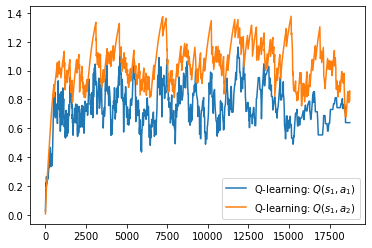

In [4]:
#プロット
import matplotlib.pyplot as plt

plt.plot(Q_num_samples, Q_1, label=r"Q-learning: $Q(s_1, a_1)$")
plt.plot(Q_num_samples, Q_2, label=r"Q-learning: $Q(s_1, a_2)$")

plt.legend()

In [35]:
def do_Q_learning_2(mdp: MDP, n_episode: int):
    S, A = mdp.S, mdp.A
    horizon = mdp.horizon

    Q_table = np.zeros((S, A))
    lr = 0.1
    eps0 = 0.5

    Q_1_vals = []
    Q_2_vals = []
    num_samples = []
    num_sample = 0

    for e in tqdm(range(n_episode)):
        s = 0
        eps = eps0 * (1 - e / 1000)
        for _ in range(horizon):
            if s == 1:
                break
            a = sample_eps_greedy_act(mdp, Q_table[s], eps)
            next_s = sample_next_state(mdp, s, a)
            greedy_pol = return_greedy_policy(Q_table)[next_s]
            #ベルマン最適作用素を適用r(s,a) + gamma(maxa')*()
            td_error =  mdp.rew[s, a] + mdp.gamma * np.sum(greedy_pol * Q_table[next_s]) - Q_table[s,a]
            Q_table[s, a] = Q_table[s,a] + lr * td_error
            s = next_s
            num_sample += 1

        Q_1_vals.append(Q_table[0, 0])
        Q_2_vals.append(Q_table[0, 1])
        num_samples.append(num_sample)
    print(Q_table)
    return num_samples, Q_1_vals, Q_2_vals
n_episode = 1000
Q_num_samples, Q_1, Q_2 = do_Q_learning_2(mdp, n_episode)



100%|██████████| 1000/1000 [00:37<00:00, 26.72it/s]

[[0.58412689 0.96779412]
 [0.         0.        ]]


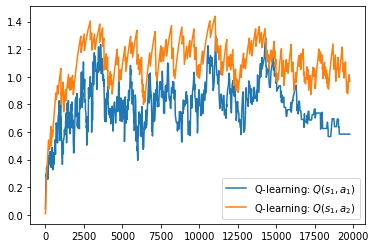

In [36]:
import matplotlib.pyplot as plt

plt.plot(Q_num_samples, Q_1, label=r"Q-learning: $Q(s_1, a_1)$")
plt.plot(Q_num_samples, Q_2, label=r"Q-learning: $Q(s_1, a_2)$")

plt.legend()

In [37]:
#SARSAの実装
def do_SARSA(mdp: MDP, n_episode: int):
    S, A = mdp.S, mdp.A
    horizon = mdp.horizon

    Q_table = np.zeros((S, A))
    lr = 0.1
    eps0 = 0.5

    Q_1_vals = []
    Q_2_vals = []
    num_samples = []
    num_sample = 0

    for e in tqdm(range(n_episode)):
        s = 0
        eps = eps0 * (1 - e / 1000)
        for _ in range(horizon):
            if s == 1:
                break
            a = sample_eps_greedy_act(mdp, Q_table[s], eps)
            next_s = sample_next_state(mdp, s, a)
            next_a = sample_eps_greedy_act(mdp, Q_table[next_s], eps)
            td_error =  mdp.rew[s, a] + mdp.gamma * Q_table[next_s,next_a]- Q_table[s,a]
            Q_table[s, a] = Q_table[s,a] + lr * td_error
            s = next_s
            num_sample += 1

        Q_1_vals.append(Q_table[0, 0])
        Q_2_vals.append(Q_table[0, 1])
        num_samples.append(num_sample)
    print(Q_table)
    return num_samples, Q_1_vals, Q_2_vals
n_episode = 1000
Q_num_samples, Q_1, Q_2 = do_Q_learning_2(mdp, n_episode)




100%|██████████| 1000/1000 [00:36<00:00, 27.15it/s]

[[0.63962972 1.13864219]
 [0.         0.        ]]


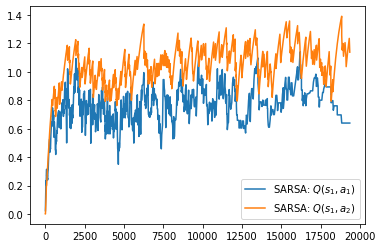

In [39]:
import matplotlib.pyplot as plt

plt.plot(Q_num_samples, Q_1, label=r"SARSA: $Q(s_1, a_1)$")
plt.plot(Q_num_samples, Q_2, label=r"SARSA: $Q(s_1, a_2)$")

plt.legend()